In [1]:
from pathlib import Path
import torch
import cv2
from ultralytics import YOLO
import math
from IPython.display import display, clear_output
from PIL import Image
import numpy as np

In [2]:
# Pfade/Dateinamen (plattformunabhängig)
MODEL_PATH_GTSDB  = Path("../models/gtsdb_nachgelabelt_plus_fussgaenger.pt")  
MODEL_PATH_GTSRB = Path("../models/gtsrb_plus_fussgaenger_colab.pt") 
VIDEO_PATH   = Path("../videos/inputs/Fussgaenger_Fast.mp4") 
OUTPUT_VIDEO = Path(f"../videos/outputs/{VIDEO_PATH.stem}_bboxes.mp4")

# Inferenz-Parameter GTSDB:
CONF_THRES_GTSDB     = 0.25   # Mindest-Konfidenz für Detections
IOU_THRES_GTSDB      = 0.45   # IoU-Schwelle für NMS (Dubletten-Unterdrückung)

# Classifications-Parameter GTSRB:
CONF_THRES_GTSRB     = 0.7   # Mindest-Konfidenz für Classifications

# Device-Handhabung:
DEVICE_AUTO = True      # True = automatisch wählen (cuda falls verfügbar, sonst cpu)
DEVICE      = "cpu"     # Wird nur benutzt, wenn DEVICE_AUTO = False

# Verarbeitungs-Parameter:
DISPLAY_EVERY = 50      # Alle n Frames eine Statusanzeige (0 = nie)

In [3]:
# Gpu oder Cpu bestimmen
_device = ("cuda" if torch.cuda.is_available() else "cpu") if DEVICE_AUTO else DEVICE

# Sanity-Checks
if not MODEL_PATH_GTSDB.exists():
    raise FileNotFoundError(f"Modell nicht gefunden: {MODEL_PATH_GTSDB}")
if not MODEL_PATH_GTSRB.exists():
    raise FileNotFoundError(f"Modell nicht gefunden: {MODEL_PATH_GTSRB}")
if not VIDEO_PATH.exists():
    raise FileNotFoundError(f"Video nicht gefunden: {VIDEO_PATH}")

# YOLOv11 laden
model_gtsdb = YOLO(str(MODEL_PATH_GTSDB))   # Detektor (GTSDB)
model_gtsrb = YOLO(str(MODEL_PATH_GTSRB))   # Klassifikator (GTSRB)

print(f"Torch: {torch.__version__} | OpenCV: {cv2.__version__} | Device: {_device}")


Torch: 2.8.0+cpu | OpenCV: 4.12.0 | Device: cpu


In [4]:
# Deutsche, sprechende Namen für die 43 GTSRB-Klassen (Ordner 00000–00042).
GTSRB_LABELS_DE = [
    "Geschwindigkeitsbegrenzung (20 km/h)",                     # 00000
    "Geschwindigkeitsbegrenzung (30 km/h)",                     # 00001
    "Geschwindigkeitsbegrenzung (50 km/h)",                     # 00002
    "Geschwindigkeitsbegrenzung (60 km/h)",                     # 00003
    "Geschwindigkeitsbegrenzung (70 km/h)",                     # 00004
    "Geschwindigkeitsbegrenzung (80 km/h)",                     # 00005
    "Ende der Geschwindigkeitsbegrenzung (80 km/h)",            # 00006
    "Geschwindigkeitsbegrenzung (100 km/h)",                    # 00007
    "Geschwindigkeitsbegrenzung (120 km/h)",                    # 00008
    "Überholverbot",                                            # 00009
    "Überholverbot für Fahrzeuge über 3,5 t",                   # 00010
    "Vorfahrt an der nächsten Kreuzung",                        # 00011
    "Vorfahrtstraße",                                           # 00012
    "Vorfahrt gewähren",                                        # 00013
    "Stop",                                                     # 00014
    "Verbot für Fahrzeuge aller Art",                           # 00015
    "Verbot für Fahrzeuge über 3,5 t",                          # 00016
    "Einfahrt verboten",                                        # 00017
    "Allgemeine Gefahrenstelle",                                # 00018
    "Gefährliche Linkskurve",                                   # 00019
    "Gefährliche Rechtskurve",                                  # 00020
    "Doppelkurve",                                              # 00021
    "Unebene Fahrbahn",                                         # 00022
    "Rutschige Fahrbahn",                                       # 00023
    "Fahrbahnverengung (rechts)",                               # 00024
    "Baustelle",                                                # 00025
    "Ampel (Gefahrenstelle)",                                   # 00026
    "Fußgänger (Gefahrenstelle)",                               # 00027
    "Kinder (Gefahrenstelle)",                                  # 00028
    "Radfahrer kreuzen (Gefahrenstelle)",                       # 00029
    "Schnee- oder Eisglätte",                                   # 00030
    "Wildwechsel",                                              # 00031
    "Ende sämtlicher Streckenverbote",                          # 00032
    "Rechts abbiegen (vorgeschrieben)",                         # 00033
    "Links abbiegen (vorgeschrieben)",                          # 00034
    "Geradeaus (vorgeschrieben)",                               # 00035
    "Geradeaus oder rechts (vorgeschrieben)",                   # 00036
    "Geradeaus oder links (vorgeschrieben)",                    # 00037
    "Rechts vorbeifahren (vorgeschrieben)",                     # 00038
    "Links vorbeifahren (vorgeschrieben)",                      # 00039
    "Kreisverkehr (vorgeschrieben)",                            # 00040
    "Ende des Überholverbots",                                  # 00041
    "Ende des Überholverbots für Fahrzeuge über 3,5 t"          # 00042
    "Fussgängerüberweg"                                         # 00043
]

TRANSLIT = str.maketrans({"ä":"ae","ö":"oe","ü":"ue","Ä":"Ae","Ö":"Oe","Ü":"Ue","ß":"ss"})
GTSRB_LABELS_ASCII = [s.translate(TRANSLIT) for s in GTSRB_LABELS_DE]

def get_gtsrb_label(index: int) -> str:
    if 0 <= index < len(GTSRB_LABELS_ASCII):
        return GTSRB_LABELS_ASCII[index]
    else:
        return f"Index not found: {index}"


In [5]:
_video_abs = Path(VIDEO_PATH).resolve()
_out_abs   = Path(OUTPUT_VIDEO).resolve()

if not _video_abs.is_file():
    raise FileNotFoundError(f"Video-Datei nicht gefunden: {_video_abs}")

cv2.setUseOptimized(True)
cv2.setNumThreads(4) 

cap = cv2.VideoCapture(str(_video_abs))
if not cap.isOpened():
    raise RuntimeError(f"Konnte Video nicht öffnen: {_video_abs}")

fps = cap.get(cv2.CAP_PROP_FPS) or 25.0
w   = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
h   = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
if w == 0 or h == 0:
    raise RuntimeError(f"Ungültige Videodimensionen für: {_video_abs}")

fourcc = cv2.VideoWriter_fourcc(*"mp4v")
writer = cv2.VideoWriter(str(_out_abs), fourcc, fps, (w, h))

def _show(frame_bgr):
    rgb = cv2.cvtColor(frame_bgr, cv2.COLOR_BGR2RGB)
    clear_output(wait=True); display(Image.fromarray(rgb))

print(f"Video: {_video_abs} | {w}x{h}@{fps:.2f} -> Ausgabe: {_out_abs}")


Video: C:\Develop\Python\PyCharmProjects\iu_computer_vision\analysis\videos\inputs\Fussgaenger_Fast.mp4 | 960x540@29.97 -> Ausgabe: C:\Develop\Python\PyCharmProjects\iu_computer_vision\analysis\videos\outputs\Fussgaenger_Fast_bboxes.mp4


In [6]:
def process_batch_detect(results, frames, writer, frame_idx):
    """
    Verarbeitet ein Batch Frames:
    - zeichnet nur YOLO-Detektionsboxen mit Confidence ein,
    - schreibt alle Frames (auch ohne Treffer) ins Video.
    """
    hws = [frm.shape[:2] for frm in frames]

    for i, (res, frm) in enumerate(zip(results, frames)):
        h, w = hws[i]
        boxes = res.boxes
        if not boxes or len(boxes) == 0:
            continue

        for b in boxes:
            x1, y1, x2, y2 = map(int, b.xyxy[0].tolist())
            conf = float(b.conf[0]) if hasattr(b, "conf") else 0.0
            x1, y1 = max(0, x1), max(0, y1)
            x2, y2 = min(w - 1, x2), min(h - 1, y2)
            if x2 <= x1 or y2 <= y1:
                continue

            cv2.rectangle(frm, (x1, y1), (x2, y2), (0, 255, 255), 2)
            cv2.putText(frm, f"{conf:.2f}", (x1, max(0, y1 - 5)),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 255), 1, cv2.LINE_AA)

    # Alle Frames schreiben (immer)
    for frm in frames:
        writer.write(frm)

    frame_idx += len(frames)
    last_frame = frames[-1] if frames else None
    return frame_idx, last_frame


In [7]:
def process_batch(results, frames, writer, frame_idx):
    """
    Verarbeitet ein Batch Frames:
    - erkennt Verkehrszeichen (YOLO-Detektionsergebnis übergeben),
    - klassifiziert alle Crops in einem Durchlauf mit model_gtsrb,
    - zeichnet Label und Boxen ein,
    - schreibt alle Frames (auch ohne Treffer) ins Video.
    """
    hws = [frm.shape[:2] for frm in frames]
    crops, assign = [], []  # Zuordnung: (frame_index, x1, y1, x2, y2)

    # 1) Crops sammeln
    for i, (res, frm) in enumerate(zip(results, frames)):
        h, w = hws[i]
        boxes = res.boxes
        if not boxes or len(boxes) == 0:
            continue
        for b in boxes:
            x1, y1, x2, y2 = map(int, b.xyxy[0].tolist())
            x1, y1 = max(0, x1), max(0, y1)
            x2, y2 = min(w - 1, x2), min(h - 1, y2)
            if x2 <= x1 or y2 <= y1:
                continue
            crops.append(frm[y1:y2, x1:x2])
            assign.append((i, x1, y1, x2, y2))

    # 2) Alle Crops auf einmal klassifizieren
    cls_results = []
    if crops:
        cls_results = model_gtsrb.predict(
            source=crops,
            device=_device,
            verbose=False
        )

    # 3) Labels einzeichnen
    for j, (i, x1, y1, x2, y2) in enumerate(assign):
        r = cls_results[j]
        probs = getattr(r, "probs", None)
        if probs is None:
            continue
        top1 = int(probs.top1)
        top1conf = float(
            getattr(probs, "top1conf", probs.data[top1]).item()
            if hasattr(probs, "data")
            else getattr(probs, "top1conf", 0)
        )
        if top1conf < CONF_THRES_GTSRB:
            continue

        label = get_gtsrb_label(top1)
        frm = frames[i]
        cv2.rectangle(frm, (x1, y1), (x2, y2), (0, 255, 0), 2)
        cv2.putText(frm, label, (x1, max(0, y1 - 5)),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 1, cv2.LINE_AA)

    # 4) Alle Frames schreiben und zählen (immer!)
    for frm in frames:
        writer.write(frm)

    frame_idx += len(frames)
    last_frame = frames[-1] if frames else None
    return frame_idx, last_frame


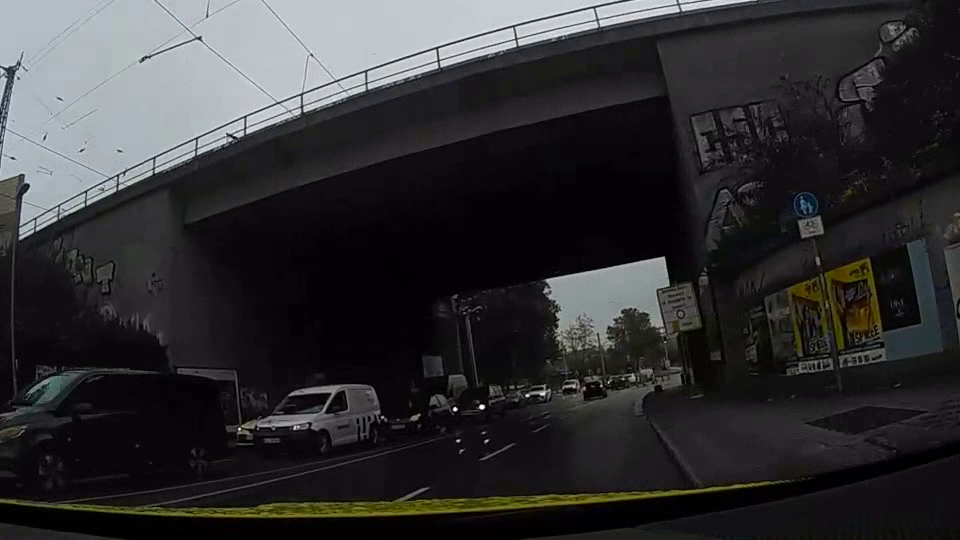

KeyboardInterrupt: 

In [8]:
# Parameter vorhanden: model, cap, writer, _device, CONF_THRES, IOU_THRES, DISPLAY_EVERY, _show, cv2, cap
BATCH_SIZE = 64
frame_idx = 0
frames = []
next_display_at = DISPLAY_EVERY if DISPLAY_EVERY and DISPLAY_EVERY > 0 else None

# Frames in Batches lesen und direkt verarbeiten
while True:
    ret, frame = cap.read()
    if not ret:
        break
    frames.append(frame)

    if len(frames) >= BATCH_SIZE:
        results = model_gtsdb.predict(
            source=frames,
            conf=CONF_THRES_GTSDB,
            iou=IOU_THRES_GTSDB,
            device=_device,
            verbose=False
        )
        frame_idx, last_frame = process_batch(results, frames, writer, frame_idx)

        if next_display_at is not None and frame_idx >= next_display_at:
            _show(last_frame)
            next_display_at += DISPLAY_EVERY

        frames.clear()

# Restbatch
if frames:
    results = model_gtsdb.predict(
        source=frames,
        conf=CONF_THRES_GTSDB,
        iou=IOU_THRES_GTSDB,
        device=_device,
        stream=True,
        verbose=False
    )
    frame_idx, last_frame = process_batch(results, frames, writer, frame_idx)

    if next_display_at is not None and frame_idx >= next_display_at:
        _show(last_frame)
        next_display_at += DISPLAY_EVERY

print(f"Fertig: {frame_idx} Frames verarbeitet.")


In [11]:
# Cleanup
cap.release()
writer.release()
cv2.destroyAllWindows()
print(f"Ausgabe gespeichert unter: {OUTPUT_VIDEO}")


Ausgabe gespeichert unter: ..\videos\outputs\Fussgaenger_Fast_bboxes.mp4
